Мы владеем сетью магазинов, в которых продаются различные товары. Наши сотрудники собрали датасет из 8523 продаж товаров в различных магазинах нашей сети. Наша задача построить модель, предсказывающую продажи каждого продукта в конкретном магазине. Используя эту модель, попробовать выявить факторы, больше всего влияющие на увеличение продаж. Описание датасета:


Variable
Description
Item_Identifier
Id продукта
Item_Weight
Вес продукта
Item_Fat_Content
Содержание жира в продукте
Item_Visibility
%полок, отведенный под наш продукт в конкретном магазине
Item_Type
Категория продукта
Item_MRP
Максимальная цена продажи продукта
Outlet_Identifier
Идентификатор магазина
Outlet_Establishment_Year
Год открытия магазина
Outlet_Size
Площадь магазина
Outlet_Location_Type
Тип города, в котором расположен магазин
Outlet_Type
Признак является ли магазин продуктовым или супермаркетом
Item_Outlet_Sales
Продажи продукта в конкретном магазине. Именно ее и надо предсказывать

В результате работы должен получиться:
− Jupyter-ноутбук с моделью
- Признаки, влияющие больше всего на уровень продаж
− Датасет, если после ваших манипуляций он отличается от исходного;
− Документ с обоснованием решения и краткими результатами: какие техники и почему использовали, что получили, что можно улучшить (можно в рамках jupyter notebook’а)

Критерии оценки:

Баллы
Что надо сделать
10
Провести EDA
10
Обработать категориальные признаки 
10
Устранить пропущенные значения
10
Изучить корреляцию признаков с данными о продажах
10
Выбрать и обосновать метрику, на основе которой будем измерять качество полученной модели
20
Построить и подобрать оптимальные параметры для любой линейной модели
20
Построить и подобрать оптимальные параметры для любой нелинейной модели
20
Провести стекинг нескольких моделей
10
Оценить качество модели на отложенной выборке
10
Выбрать топ 3 признака больше всего влияющие на объемы продаж

Все шаги решения должны сопровождаться подробным описанием полученных результатов и обоснованием выбора того или иного шага! За отсутствие описания так же будут снижаться баллы.

Максимальное доступное количество баллов - 130
Для получения зачета надо набрать минимум 80 баллов
Для получения зачета с отличием надо набрать минимум 120 баллов


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns  
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_curve, roc_auc_score, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data.csv')
print(data.shape)
data.head()

(8523, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [4]:
# убираем не нужные колонки Ид
dataset = data.drop(['Item_Identifier','Outlet_Identifier'], axis = 1)

In [5]:
cat_feat = list(dataset.dtypes[dataset.dtypes == object].index)
print('Категориальные признаки \n',cat_feat)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
dataset[cat_feat] = dataset[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in dataset if f not in (cat_feat + ['Id', 'Item_Outlet_Sales'])]
print('Непрерывные признаки \n', num_feat)

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = dataset[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)

Категориальные признаки 
 ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
Непрерывные признаки 
 ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
Item_Fat_Content         5
Item_Type               16
Outlet_Size              4
Outlet_Location_Type     3
Outlet_Type              4
dtype: int64


In [6]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(dataset[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train))

dummy_train = dummy_train[dummy_cols]

# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X = pd.concat([dataset[num_feat].fillna(-999),
                     dummy_train], axis=1)

# Подготовим отдельные данные для линейной и логистической регрессии
from sklearn.preprocessing import StandardScaler

train_median = dataset[num_feat].median()

X_lin = pd.concat([dataset[num_feat].fillna(train_median),
                     dataset[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

y = dataset['Item_Outlet_Sales']

# Разбиваем на train/test до нормализации
splitter = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=777)

for train_index, test_index in splitter.split(X, np.zeros(X.shape[0])):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    X_lin_train = X_lin.iloc[train_index]
    X_lin_test = X_lin.iloc[test_index]
    
    
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

y_train_int = y_train.astype(int)

scaler = StandardScaler()
scaler.fit(X_lin_train[num_feat])

X_lin_train[num_feat] = scaler.transform(X_lin_train[num_feat])
X_lin_test[num_feat] = scaler.transform(X_lin_test[num_feat])

print(X.shape)
X_lin_train.head()


(8523, 36)


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Weight_NaN,Item_Visibility_NaN,Item_MRP_NaN,Outlet_Establishment_Year_NaN,Item_Fat_Content_NaN,Item_Type_NaN,...,Item_Fat_Content_low fat,Item_Type_Soft Drinks,Outlet_Size_nan,Outlet_Type_Supermarket Type2,Item_Type_Baking Goods,Item_Type_Fruits and Vegetables,Item_Type_Seafood,Item_Type_Meat,Outlet_Type_Supermarket Type1,Item_Type_Household
8450,-1.169727,-0.221590,-0.513462,-0.099456,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6703,-0.719648,-0.370512,-0.607104,0.138972,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5678,-0.507077,0.400675,0.212862,1.092684,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2212,-1.590118,0.243787,-0.448171,0.496614,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
674,1.607941,-0.482321,-0.818548,1.331112,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


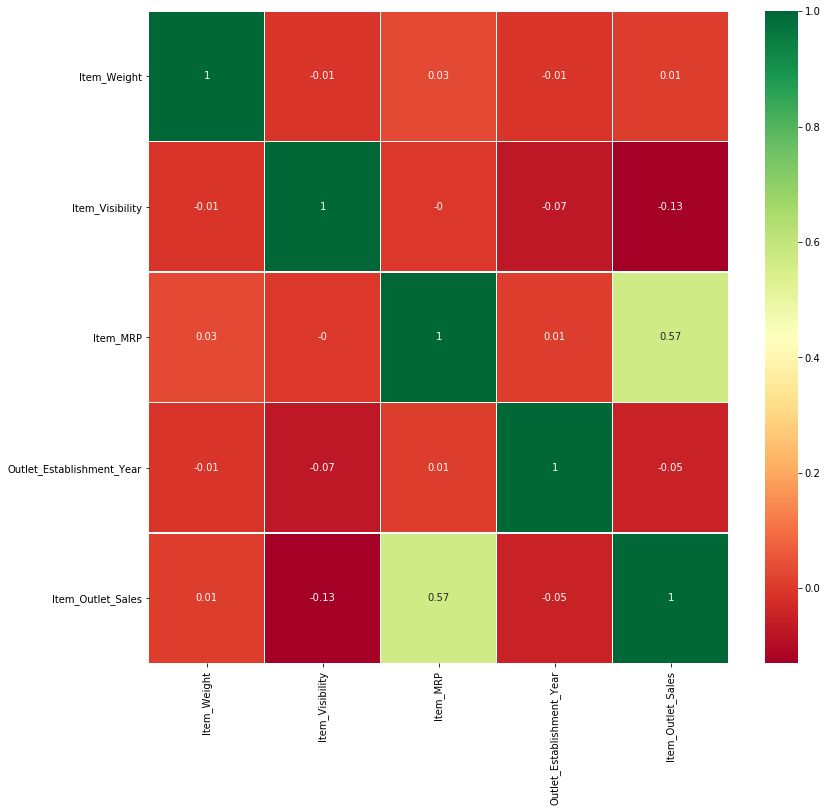

In [60]:
# Изучим корреляцию признаков
correlation_matrix = data.corr(method ='pearson').round(2)
# annot = True чтобы печатать значение внутри ячейки матрицы
sns.heatmap(data=correlation_matrix, yticklabels=True,xticklabels=True, annot=True, cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(13,12)
plt.show()


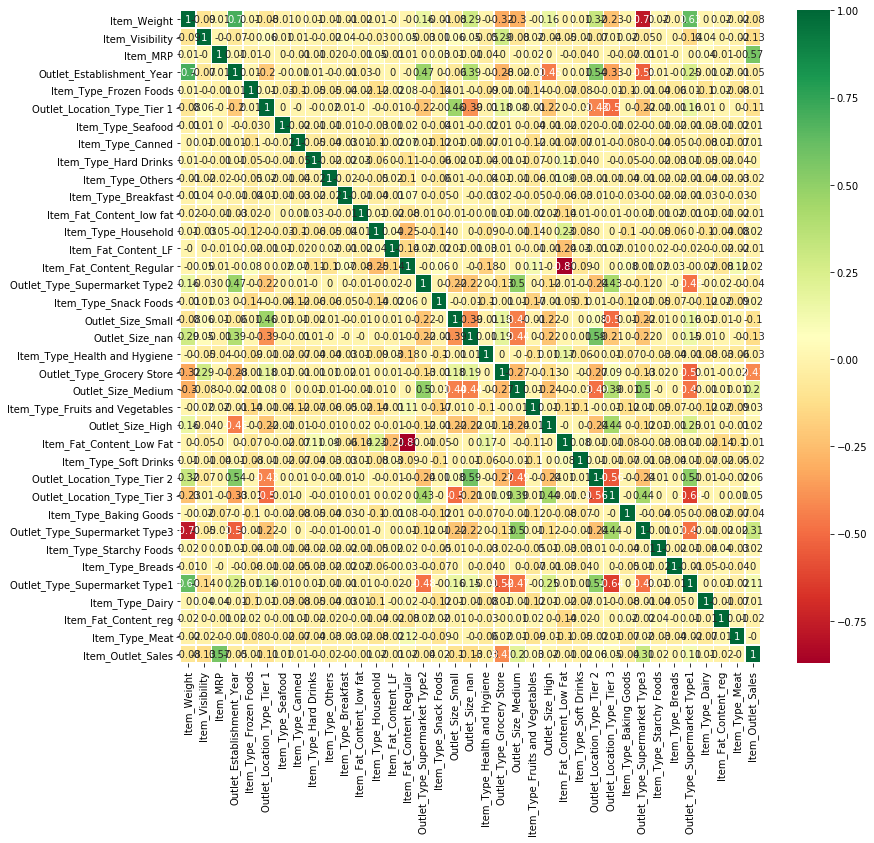

In [69]:
# Изучим корреляцию признаков
correlation_matrix = pd.concat([X,dataset.Item_Outlet_Sales], axis = 1).corr(method ='pearson').round(2)
# annot = True чтобы печатать значение внутри ячейки матрицы
sns.heatmap(data=correlation_matrix, yticklabels=True,xticklabels=True, annot=True, cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(13,12)
plt.show()

In [21]:
# Обучим случайный лес И выведем важность признаков
def crossValidation(model, X, y, N = 5):
  kf = KFold(n_splits=N, shuffle=True)
  print(cross_val_score(model, X, y, cv=kf).mean())

from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=10, max_depth=7, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_lin_train, y_train.astype(int))
#crossValidation(clf_rf, X_train, y_train_int)  

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [23]:
# Список наиболее влияющих признаков !!!

imp = pd.Series(clf_rf.feature_importances_)
print(imp.sort_values(ascending=False)[:10])
X_lin_train.columns.take(imp.sort_values(ascending=False)[:10].index)

2     0.411112
0     0.146338
1     0.145714
17    0.041603
3     0.033959
19    0.020813
34    0.017571
26    0.015567
42    0.014744
15    0.013023
dtype: float64


Index(['Item_MRP', 'Item_Weight', 'Item_Visibility',
       'Outlet_Type_Grocery Store', 'Outlet_Establishment_Year',
       'Item_Fat_Content_Regular', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Meat', 'Item_Type_Health and Hygiene'],
      dtype='object')

In [27]:
#Обучим логистическую регрессию
# В логистическую регрессию нужно передавать целые данные, поэтому целевые значения преобразуем к int
# также обучим кросс валидационную модель, чтобы избежать переобучения и сразу получить лучшие данные
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression()
clf_lr.fit(X_lin_train, y_train_int)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
#Обучим линейную регрессию RidgeCV
# также обучим кросс валидационную модель, чтобы избежать переобучения и сразу получить лучшие данные
# Ridge модель лучше описывает данные чем Линейная регрессия
from sklearn.linear_model import Ridge
clf_ll = Ridge()
clf_ll.fit(X_lin_train, y_train)
#crossValidation(clf_ll, X_lin_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [30]:
# Проверяем точность моделей на тестовых данных
show_auc(y_test,clf_lr.predict(X_lin_test), 'clf_lr')
show_auc(y_test,clf_ll.predict(X_lin_test), 'clf_ll')
show_auc(y_test,clf_rf.predict(X_lin_test), 'clf_rf')

Процент точности предсказания по средней квадратичной ошибке в моделе clf_lr : 0.3639
Процент точности предсказания по средней квадратичной ошибке в моделе clf_ll : 0.4885
Процент точности предсказания по средней квадратичной ошибке в моделе clf_rf : 0.3086


In [25]:
#Функции стекинга и графика ROC
def show_auc(y, y_pred, plot_label='', prin=True):    
    auc_val = 1 - mean_squared_error(y, y_pred.astype(int), squared=False)/ np.mean(y)
    print('Процент точности предсказания по средней квадратичной ошибке в моделе {0:} : {1:.4f}'.format(plot_label,auc_val))

def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

In [35]:
#Стекинг
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=5, random_state=555)

meta_train = []
meta_test = []
col_names = []

print('LR features...')
meta_tr, meta_te = get_meta_features(clf_lr, X_lin_train, y_train.astype(int), X_lin_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')


LR features...


In [37]:

print('LL features...')
meta_tr, meta_te = get_meta_features(clf_ll, X_lin_train, y_train.astype(int), X_lin_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('ll_pred')



LL features...


In [38]:
print('RF features...')
meta_tr, meta_te = get_meta_features(clf_rf, X_lin_train, y_train.astype(int), X_lin_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')


RF features...


In [39]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

from sklearn.ensemble import RandomForestRegressor

clf_lr_meta = RandomForestRegressor()
clf_lr_meta.fit(X_meta_train, y_train)
y_pred_meta_test = clf_lr_meta.predict(X_meta_test)

show_auc(y_test, y_pred_meta_test, 'stack')

Процент точности предсказания по средней квадратичной ошибке в моделе stack : 0.4710


Процент точности предсказания по средней квадратичной ошибке в моделе Ridge : 0.4886
Процент точности предсказания по средней квадратичной ошибке в моделе LogisticRegression : 0.3574
Процент точности предсказания по средней квадратичной ошибке в моделе RandomForest : 0.2801


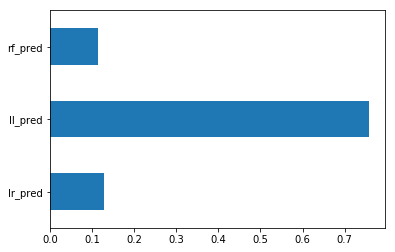

In [40]:
y_pred = clf_ll.predict(X_lin_test)
show_auc(y_test, y_pred, 'Ridge')

y_pred = clf_lr.predict(X_lin_test)
show_auc(y_test, y_pred, 'LogisticRegression')

y_pred = clf_rf.predict(X_lin_test)
show_auc(y_test, y_pred, 'RandomForest')

pd.Series(clf_lr_meta.feature_importances_.flatten(), index=X_meta_train.columns).plot(kind='barh')



In [ ]:
# Линейная модель дала самую высокю точность предсказания

In [ ]:
Покажем какие коэффициенты в Линейной Модели самыебольшие 

In [47]:
#Обучим линейную регрессию RidgeCV
# также обучим кросс валидационную модель, чтобы избежать переобучения и сразу получить лучшие данные
# Ridge модель лучше описывает данные чем Линейная регрессия
from sklearn.linear_model import RidgeCV
clf_ll = RidgeCV()
clf_ll.fit(X_lin_train, y_train)
y_pred = clf_ll.predict(X_lin_test)
show_auc(y_test, y_pred, 'Ridge')


Процент точности предсказания по средней квадратичной ошибке в моделе Ridge : 0.4886


In [67]:
[(X_lin_train.columns[i],clf_ll.coef_[i])  for i in np.argsort([np.abs(i) for i in clf_ll.coef_])[-10:]]

[('Outlet_Size_Medium', 112.17914497719266),
 ('Outlet_Location_Type_Tier 1', -122.35562064962437),
 ('Outlet_Establishment_Year', 145.25396127745262),
 ('Outlet_Location_Type_Tier 3', 234.519134099849),
 ('Outlet_Type_Supermarket Type2', -346.5377014059959),
 ('Item_Weight_NaN', 460.05994364774506),
 ('Outlet_Type_Supermarket Type1', 560.1859542035886),
 ('Item_MRP', 967.1790304165206),
 ('Outlet_Type_Supermarket Type3', 1347.1429313818408),
 ('Outlet_Type_Grocery Store', -1560.7911841794332)]

In [ ]:
самые важные факторы :
    
    Outlet_Type
    Item_MRP
    Outlet_Location
    
    
    
    

In [ ]:
Рекомендации :
    
    выставлять на самых видных местах товар по которым нужно увеличивать продажи 
    При этом эффективнее будут продаваться товары с меньшей ценой
    Тип магазина с лучшими продажами - супермаркет type1
    лучшее местонахождение магазина - Tier 3
    
    
    
    
    